In [1]:
pip install livelossplot


In [2]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from livelossplot.inputs.keras import PlotLossesCallback
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display, HTML
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import io
from keras.optimizers import Adam, SGD, RMSprop
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.regularizers import l1, l2
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import layers
from kerastuner import HyperModel

Using TensorFlow backend


<ipython-input-3-ed3826f06a10>:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


## 1. Data preparation

### 1.1 Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2 Split the training data into training and validation sets

In [5]:


import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

def unpickle(file_path):
    """Load pickled data from a file."""
    with open(file_path, 'rb') as file:
        data_dict = pickle.load(file, encoding='bytes')
    return data_dict

def load_cifar10_to_dataframe(data_paths):
    """Load CIFAR-10 data batches and convert them to a DataFrame."""
    data_frames = []

    for path in data_paths:
        batch_data = unpickle(path)
        df = pd.DataFrame(batch_data[b'data'])
        df['label'] = batch_data[b'labels']
        data_frames.append(df)

    combined_df = pd.concat(data_frames, ignore_index=True)
    return combined_df

# Paths to CIFAR-10 data batches
data_paths = [
    '/content/drive/My Drive/data_batch_1',
    '/content/drive/My Drive/data_batch_2',
    '/content/drive/My Drive/data_batch_3',
    '/content/drive/My Drive/data_batch_4',
    '/content/drive/My Drive/data_batch_5'
]

# Load training data
train_data = load_cifar10_to_dataframe(data_paths)
print(train_data.head())

# Load test data
test_data = load_cifar10_to_dataframe(['/content/drive/My Drive/test_batch'])

# Separate features and labels
X_train = train_data.drop(columns='label')
y_train = train_data['label']

X_test = test_data.drop(columns='label')
y_test = test_data['label']

# Split the training data into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)



     0    1    2    3    4    5    6    7    8    9  ...  3063  3064  3065  \
0   59   43   50   68   98  119  139  145  149  149  ...    58    65    59   
1  154  126  105  102  125  155  172  180  142  111  ...    42    67   101   
2  255  253  253  253  253  253  253  253  253  253  ...    83    80    69   
3   28   37   38   42   44   40   40   24   32   43  ...    39    59    42   
4  170  168  177  183  181  177  181  184  189  189  ...    88    85    82   

   3066  3067  3068  3069  3070  3071  label  
0    46    57   104   140    84    72      6  
1   122   133   136   139   142   144      9  
2    66    72    79    83    83    84      9  
3    44    48    38    28    37    46      4  
4    83    79    78    82    78    80      1  

[5 rows x 3073 columns]


### 1.3 Data Exploration

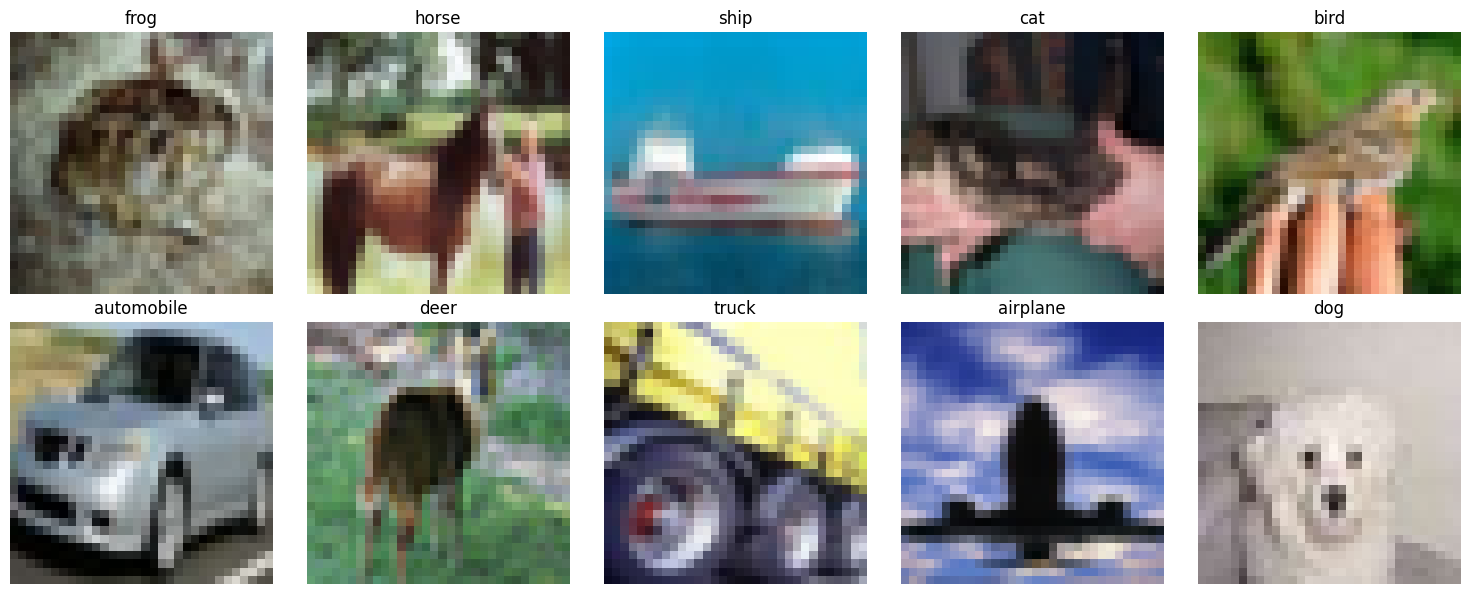

In [6]:

import pickle
import pandas as pd
import matplotlib.pyplot as plt

def load_label_names(meta_file_path):
    """Load label names from the CIFAR-10 meta file."""
    with open(meta_file_path, 'rb') as file:
        meta_data = pickle.load(file, encoding='bytes')
    return [name.decode('utf-8') for name in meta_data[b'label_names']]

# Load label names from the meta file
label_names = load_label_names('/content/drive/My Drive/batches.meta')

def display_cifar_images(images_df, labels_series, label_names_list):
    """Display a sample of CIFAR-10 images with their corresponding labels."""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for idx, ax in enumerate(axes.ravel()):
        image_data = images_df.iloc[idx].values.reshape(3, 32, 32).transpose(1, 2, 0)
        ax.imshow(image_data)
        ax.set_title(label_names_list[labels_series.iloc[idx]])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Extract a sample image for each unique label
sample_images = []
sample_labels = []

for unique_label in y_train.unique():
    sample = X_train[y_train == unique_label].iloc[0]
    sample_images.append(sample)
    sample_labels.append(unique_label)

# Convert the sample images and labels to DataFrame and Series respectively
sample_images_df = pd.DataFrame(sample_images)
sample_labels_series = pd.Series(sample_labels)

# Display the sample images
display_cifar_images(sample_images_df, sample_labels_series, label_names)


In [7]:


def display_class_distribution(dataset):
    """Display the distribution of classes in the given dataset."""

    # Mapping of CIFAR-10 labels to their respective class names
    class_labels = {
        0: "Airplane", 1: "Automobile", 2: "Bird", 3: "Cat", 4: "Deer",
        5: "Dog", 6: "Frog", 7: "Horse", 8: "Ship", 9: "Truck"
    }

    # Compute the counts and percentages of each class
    total_samples = len(dataset)
    class_counts = dataset["label"].value_counts()
    class_percentages = (class_counts / total_samples) * 100

    # Display the distribution
    print("Class Distribution:")
    for label_id, count, percentage in zip(class_counts.index, class_counts.values, class_percentages.values):
        print(f"{class_labels[label_id]:<20s}:   {count} samples ({percentage:.2f}%)")

# Display the class distribution for the training dataset
display_class_distribution(train_data)


Class Distribution:
Frog                :   5000 samples (10.00%)
Truck               :   5000 samples (10.00%)
Deer                :   5000 samples (10.00%)
Automobile          :   5000 samples (10.00%)
Bird                :   5000 samples (10.00%)
Horse               :   5000 samples (10.00%)
Ship                :   5000 samples (10.00%)
Cat                 :   5000 samples (10.00%)
Dog                 :   5000 samples (10.00%)
Airplane            :   5000 samples (10.00%)


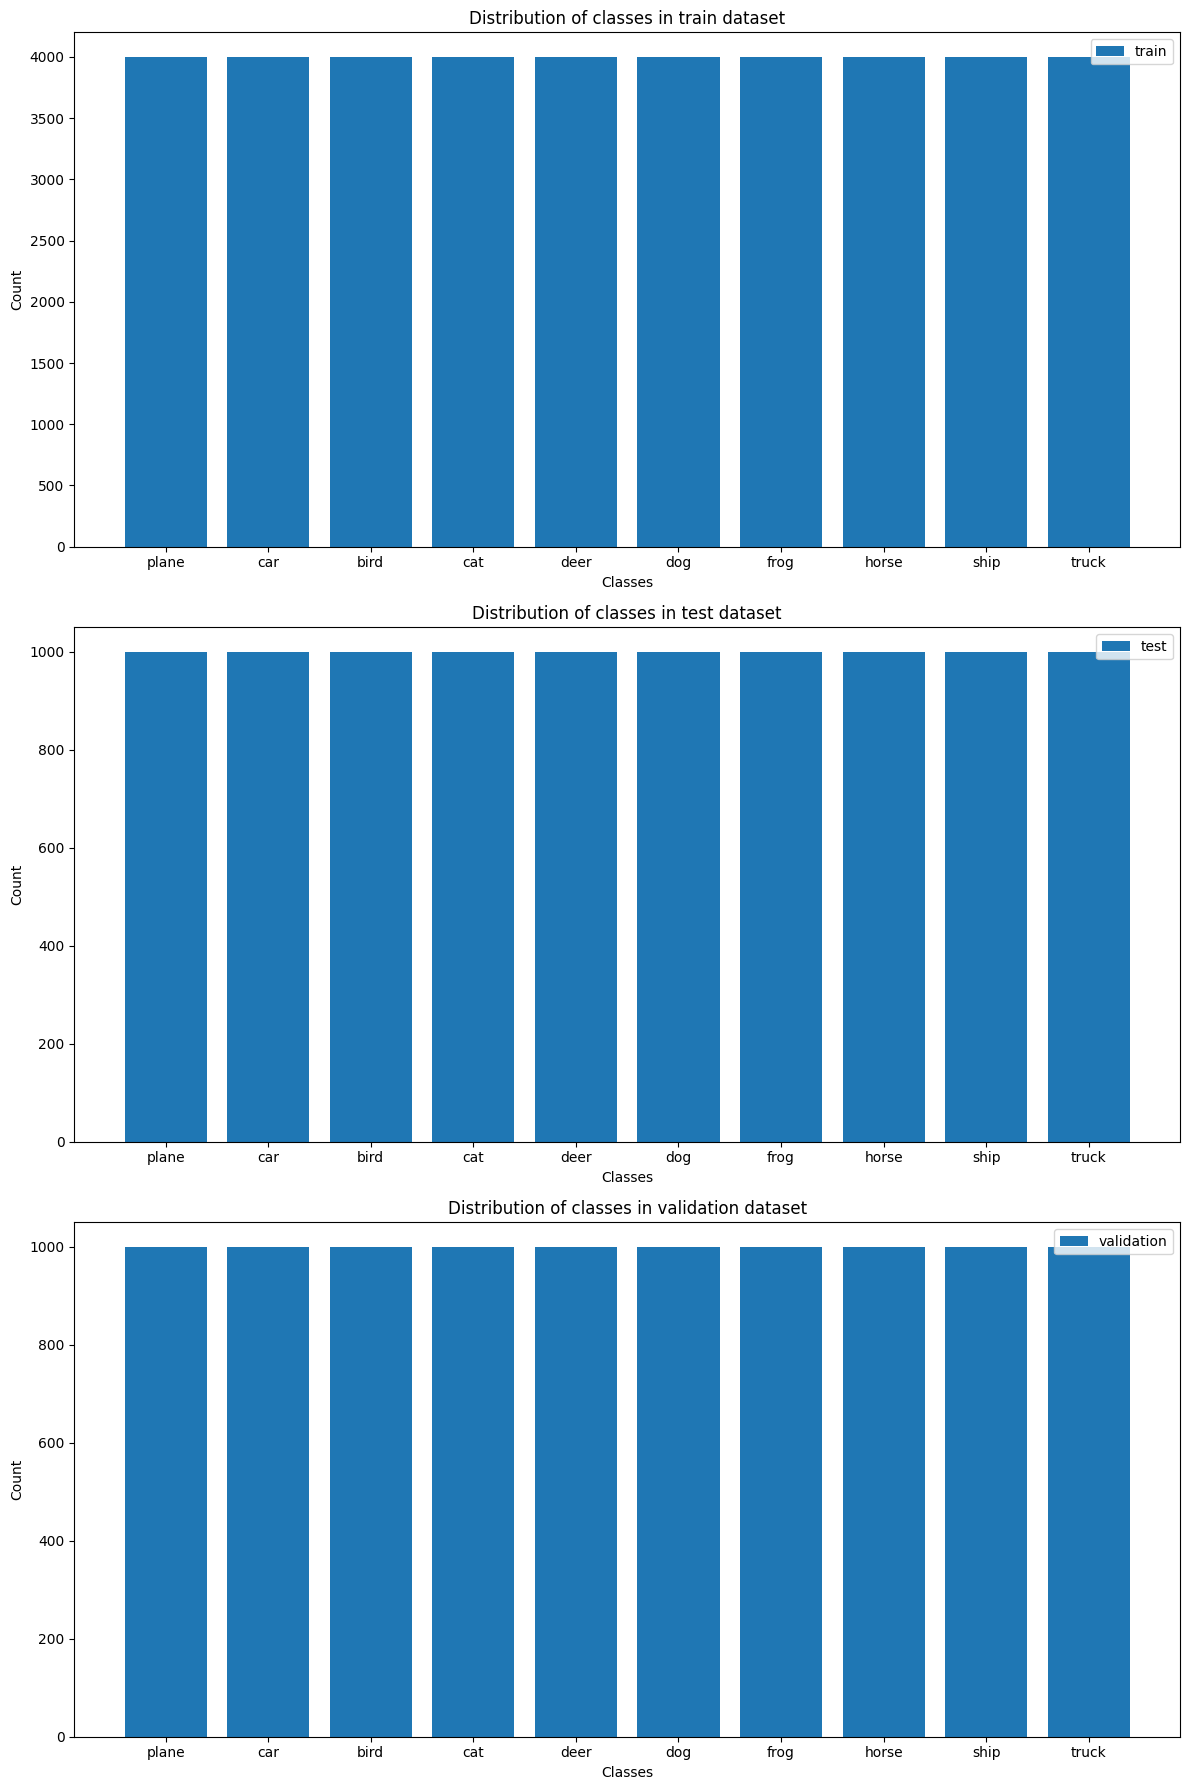

In [8]:
import numpy as np
import matplotlib.pyplot as plt

labels = {
    0: "plane", 1: "car", 2: "bird", 3: "cat", 4: "deer",
    5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}

def plot_distribution(ax, y_data, label):
    label_counts = np.bincount(y_data)
    ax.bar(labels.values(), label_counts, label=label)
    ax.set_title(f'Distribution of classes in {label} dataset')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Count')
    ax.legend()

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

plot_distribution(axes[0], y_train, 'train')
plot_distribution(axes[1], y_test, 'test')
plot_distribution(axes[2], y_val, 'validation')

plt.tight_layout()
plt.show()


### 1.4 Data Preprocessing

In [9]:
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

def preprocess_data(input_data):


    # Reshape the data and normalize to the range [0, 1]
    reshaped_data = input_data.values.reshape(-1, 32, 32, 3).astype('float32')
    normalized_data = reshaped_data / 255.0

    return normalized_data

# Preprocess the data subsets
X_train = preprocess_data(X_train)
X_val = preprocess_data(X_val)
X_test = preprocess_data(X_test)

# Display the shape of the preprocessed data subsets
print("Training set shapes:", X_train.shape, y_train.shape)
print("Validation set shapes:", X_val.shape, y_val.shape)
print("Test set shapes:", X_test.shape, y_test.shape)

# Convert the labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=10)  # CIFAR-10 has 10 classes
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Initialize an image data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,  # Allow horizontal flipping for CIFAR-10 images
    vertical_flip=False    # Vertical flipping not suitable for CIFAR-10
)

# Fit the data generator to the training data
datagen.fit(X_train)


Training set shapes: (40000, 32, 32, 3) (40000,)
Validation set shapes: (10000, 32, 32, 3) (10000,)
Test set shapes: (10000, 32, 32, 3) (10000,)


## 2. CNN


### 2.1 Define the Baseline Model

### 2.2 Baseline Model Training

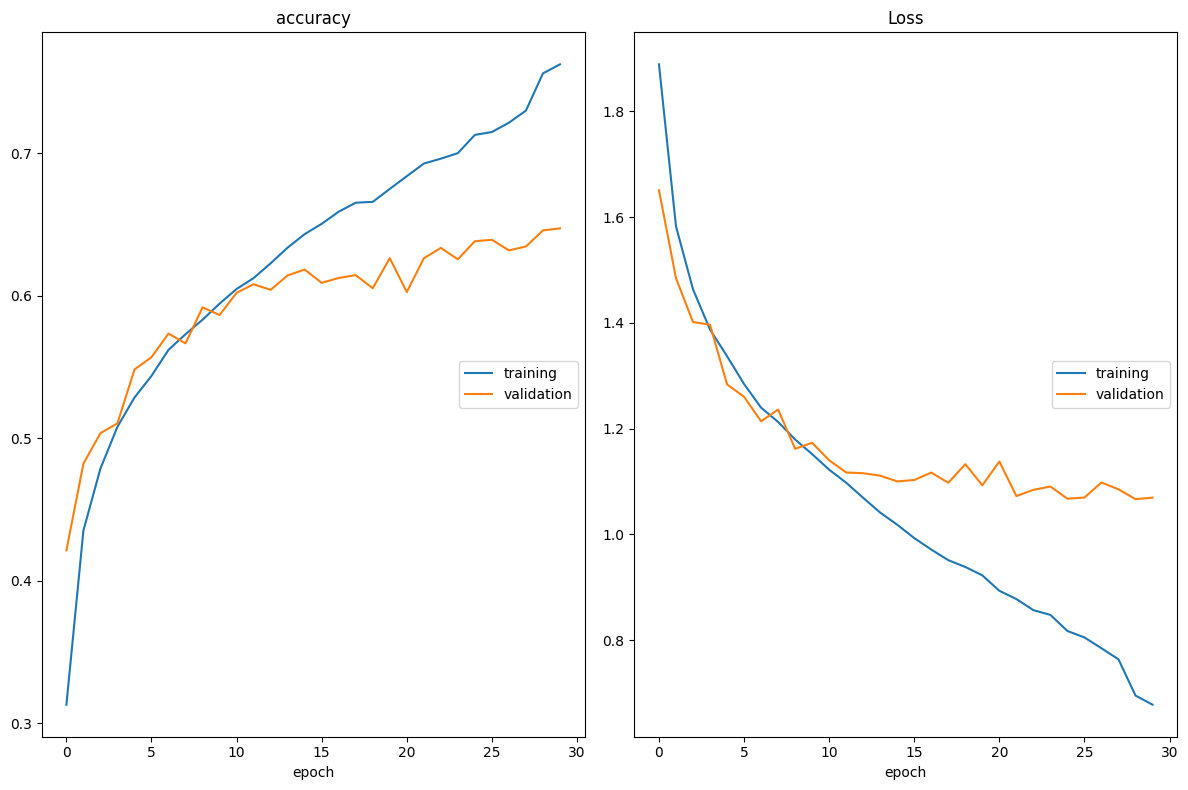

accuracy
	training         	 (min:    0.313, max:    0.762, cur:    0.762)
	validation       	 (min:    0.421, max:    0.647, cur:    0.647)
Loss
	training         	 (min:    0.678, max:    1.889, cur:    0.678)
	validation       	 (min:    1.067, max:    1.651, cur:    1.069)

Epoch 30: val_accuracy improved from 0.64580 to 0.64720, saving model to best_model.h5
157/157 [==============================] - 1s 8ms/step - loss: 0.6778 - accuracy: 0.7623 - val_loss: 1.0695 - val_accuracy: 0.6472 - lr: 2.0000e-04


In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def create_cnn_model():
    """Define and return a CNN model for CIFAR-10 classification."""

    model = Sequential([
        # First convolutional layer
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(2, 2),

        # Second convolutional layer
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Fully connected layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])

    return model

# Instantiate the model
cnn_model = create_cnn_model()

# Compile the CNN model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    cooldown=2,
    min_lr=0.00001
)

def prepare_callbacks():
    """Prepare and return a list of callbacks for the training process."""
    return [
        PlotLossesCallback(),  # For live plotting during training
        model_checkpoint,
        early_stopping,
        reduce_learning_rate
    ]

def train_cnn_model(model, train_features, train_labels, val_features, val_labels):
    """Train the CNN model and return the training history."""
    history = model.fit(
        train_features,
        train_labels,
        batch_size=256,
        epochs=30,
        validation_data=(val_features, val_labels),
        callbacks=prepare_callbacks(),
        verbose=1
    )
    return history

# Display the model architecture
cnn_model.summary()

# Train the CNN model
cnn_history = train_cnn_model(cnn_model, X_train, y_train, X_val, y_val)




In [11]:
# Display the model architecture
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

### 2.3 Baseline Model Evaluation

In [ ]:
cnn_score = cnn_model.evaluate(X_val, y_val, verbose=0)
print('Baseline Validation loss:', cnn_score[0])
print('Baseline Validation accuracy:', cnn_score[1])

Baseline Validation loss: 1.0365302562713623
Baseline Validation accuracy: 0.6539999842643738


### Comparing Different CNN Module

## 3.1 VGG 11

## define VGG 11 model and train

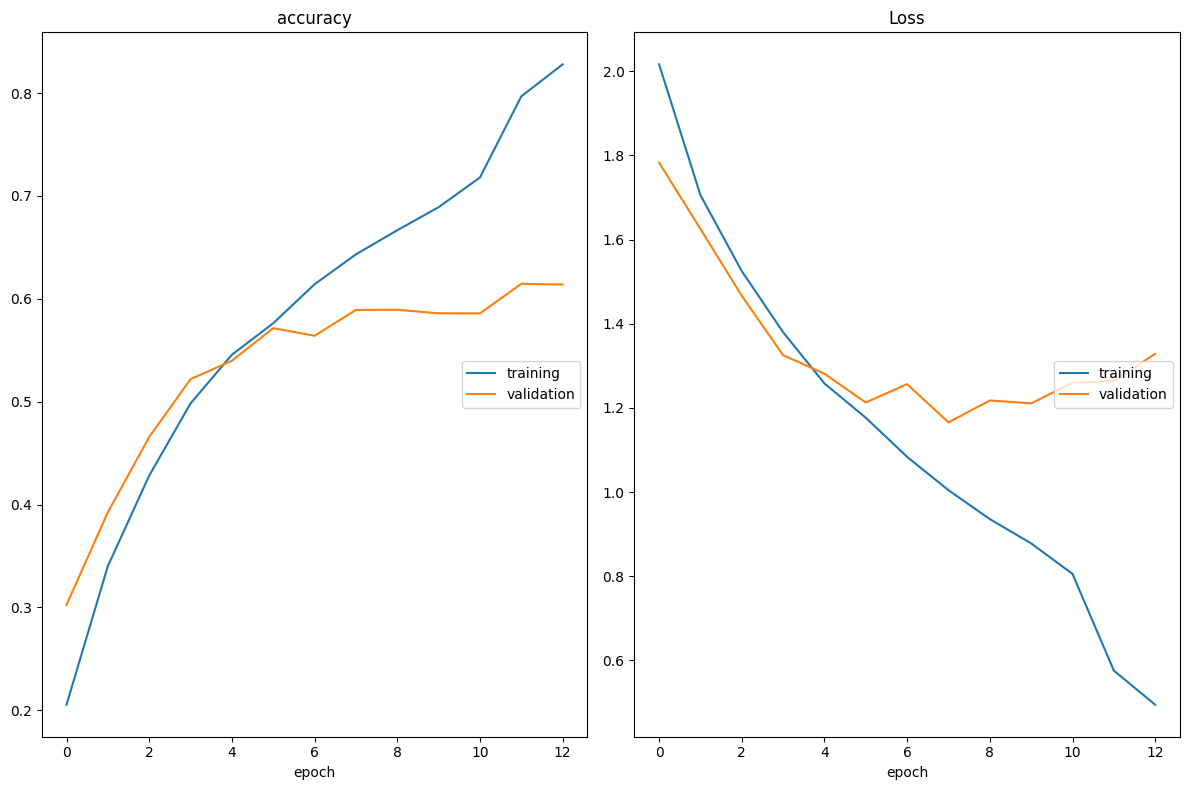

accuracy
	training         	 (min:    0.205, max:    0.828, cur:    0.828)
	validation       	 (min:    0.303, max:    0.615, cur:    0.614)
Loss
	training         	 (min:    0.495, max:    2.016, cur:    0.495)
	validation       	 (min:    1.166, max:    1.783, cur:    1.329)
Restoring model weights from the end of the best epoch: 8.
157/157 [==============================] - 2s 13ms/step - loss: 0.4948 - accuracy: 0.8280 - val_loss: 1.3288 - val_accuracy: 0.6139 - lr: 2.0000e-04
Epoch 13: early stopping


In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


def create_vgg11_model(input_shape, num_classes):
    """Define and return a VGG11-like model for image classification."""

    # Initialize a sequential model
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 4
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 5
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create the VGG11 model tailored for CIFAR-10
vgg11 = create_vgg11_model((32, 32, 3), 10)
vgg11.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
vgg11.summary()

# Define callbacks for training
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('vgg11_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001, cooldown=2, min_lr=0.00001)

def train_model(model, train_features, train_labels, val_features, val_labels):
    """Train the provided model and return the training history."""
    callbacks = [
        PlotLossesCallback(),  # For live plotting during training
        checkpoint,
        earlystop,
        reduce_lr
    ]
    history = model.fit(
        train_features,
        train_labels,
        batch_size=256,
        epochs=30,
        validation_data=(val_features, val_labels),
        callbacks=callbacks
    )
    return history

# Train the VGG11 model
history_vgg11 = train_model(vgg11, X_train, y_train, X_val, y_val)


In [13]:
# Display the model architecture
vgg11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
vgg11_score = vgg11.evaluate(X_val, y_val, verbose=0)
print('VGG11 Validation loss:', vgg11_score[0])
print('VGG11 Validation accuracy:', vgg11_score[1])

VGG11 Validation loss: 1.1720166206359863
VGG11 Validation accuracy: 0.5950000286102295


### 3.2 VGG16

## define the VGG16 model and train

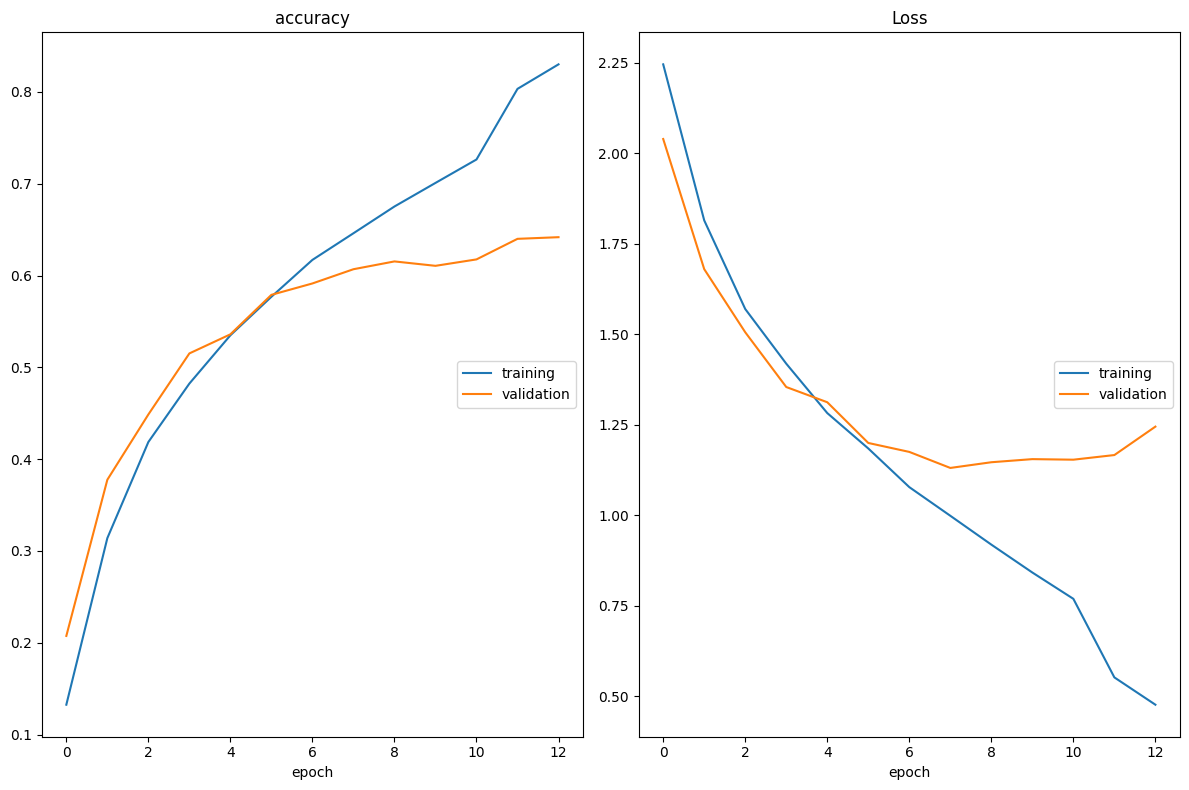

accuracy
	training         	 (min:    0.133, max:    0.830, cur:    0.830)
	validation       	 (min:    0.207, max:    0.642, cur:    0.642)
Loss
	training         	 (min:    0.477, max:    2.246, cur:    0.477)
	validation       	 (min:    1.131, max:    2.040, cur:    1.245)
Restoring model weights from the end of the best epoch: 8.
157/157 [==============================] - 8s 53ms/step - loss: 0.4770 - accuracy: 0.8300 - val_loss: 1.2451 - val_accuracy: 0.6418 - lr: 2.0000e-04
Epoch 13: early stopping


In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_vgg16_model(input_shape, num_classes):
    """Define and return a VGG16-like model for image classification, tailored for CIFAR-10."""

    # Initialize a sequential model
    model = Sequential([
        # Block 1
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 2
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 3
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),

        # Fully connected layers
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create the VGG16 model tailored for CIFAR-10
vgg16 = create_vgg16_model((32, 32, 3), 10)
vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
vgg16.summary()

# Define callbacks for training
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('vgg16_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001, cooldown=2, min_lr=0.00001)

def train_model(model, train_features, train_labels, val_features, val_labels):
    """Train the provided model and return the training history."""
    callbacks = [
        PlotLossesCallback(),  # For live plotting during training
        checkpoint,
        earlystop,
        reduce_lr
    ]
    history = model.fit(
        train_features,
        train_labels,
        batch_size=256,
        epochs=30,
        validation_data=(val_features, val_labels),
        callbacks=callbacks
    )
    return history

# Train the VGG16 model
history_vgg16 = train_model(vgg16, X_train, y_train, X_val, y_val)


In [15]:
# Display the model architecture
vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                 

In [ ]:
vgg16_score = vgg16.evaluate(X_val, y_val, verbose=0)
print('VGG16 Validation loss:', vgg16_score[0])
print('VGG16 Validation accuracy:', vgg16_score[1])

VGG16 Validation loss: 1.1240453720092773
VGG16 Validation accuracy: 0.6107000112533569


### 3.3 Resnet 50

## define ResNet50 model and train

In [ ]:


from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from keras.models import Model
from keras.optimizers import Adam

def identity_block(input_tensor, kernel_size, filters, stage, block):
    filter1, filter2, filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filter1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = ReLU()(x)

    x = Conv2D(filter2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = ReLU()(x)

    x = Conv2D(filter3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = ReLU()(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filter1, filter2, filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filter1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = ReLU()(x)

    x = Conv2D(filter2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = ReLU()(x)

    x = Conv2D(filter3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filter3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def ResNet50(input_shape=(32, 32, 3), classes=10):
    input_tensor = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(input_tensor)
    x = BatchNormalization(name='bn_conv1')(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(1, 23):  # 22 identity blocks in stage 4
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b' + str(i))

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    output_tensor = Dense(classes, activation='softmax', name='fc' + str(classes))(x)

    model = Model(input_tensor, output_tensor, name='resnet50')

    return model

# Create the ResNet50 model.
ResNet50_model = ResNet50(input_shape=(32, 32, 3), classes=10)

# Compile the model.
ResNet50_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary.
ResNet50_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 re_lu (ReLU)                (None, 16, 16, 64)           0         ['bn_conv1[0][0]']     

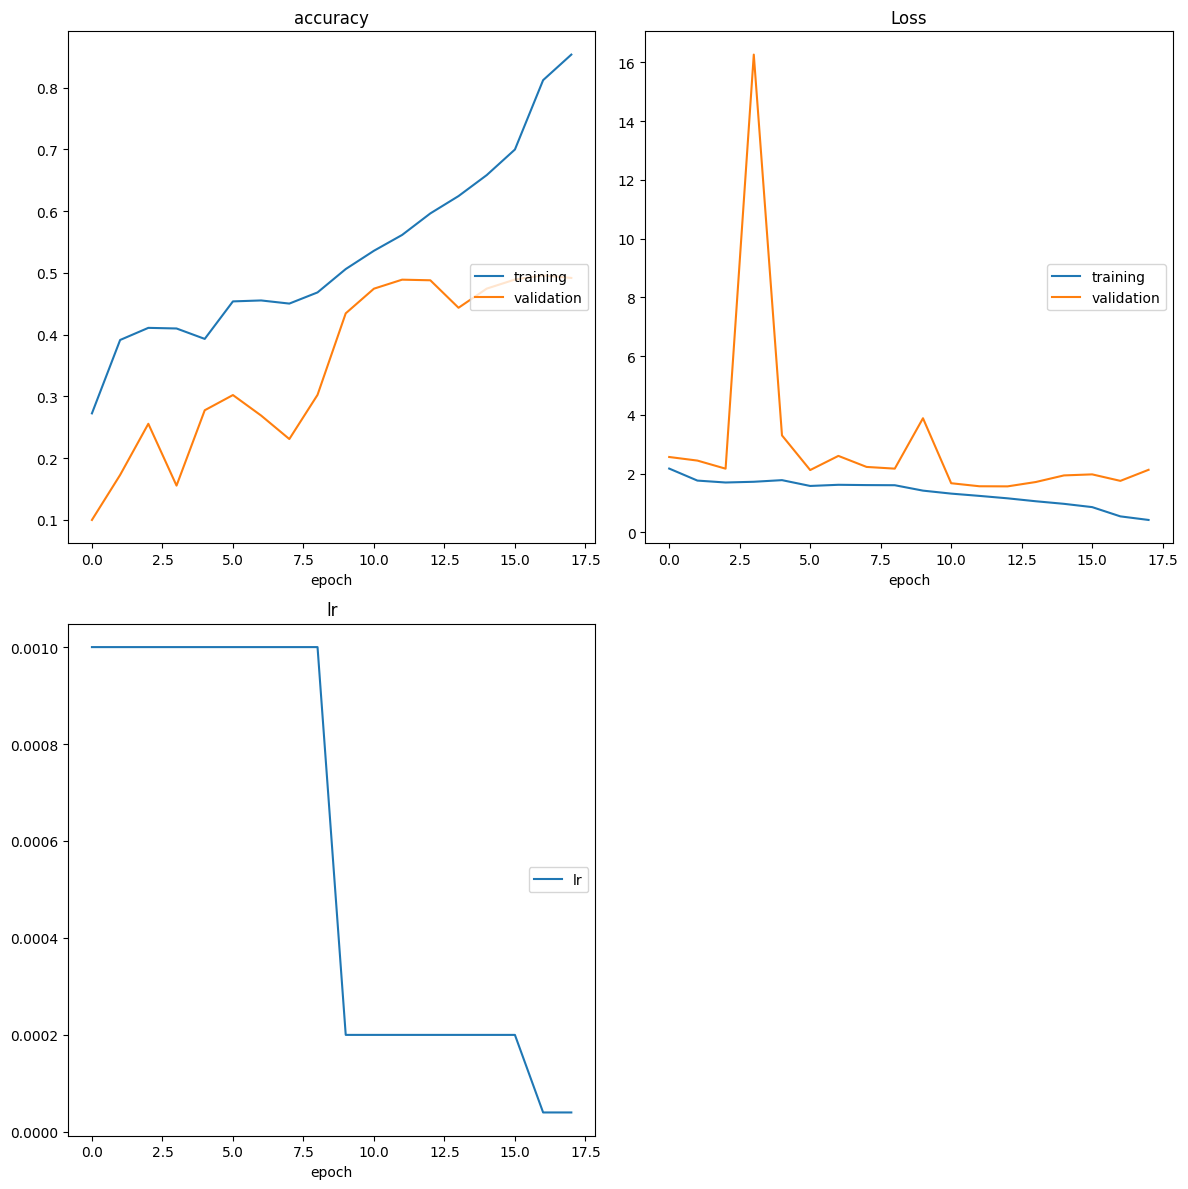

accuracy
	training         	 (min:    0.273, max:    0.853, cur:    0.853)
	validation       	 (min:    0.100, max:    0.496, cur:    0.492)
Loss
	training         	 (min:    0.425, max:    2.174, cur:    0.425)
	validation       	 (min:    1.568, max:   16.265, cur:    2.132)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
157/157 [==============================] - 14s 92ms/step - loss: 0.4247 - accuracy: 0.8533 - val_loss: 2.1316 - val_accuracy: 0.4918 - lr: 4.0000e-05
Epoch 18: early stopping


In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0, mode='auto', restore_best_weights=True)
checkpoint = ModelCheckpoint('best_resnet34_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.00001)
plot_losses = PlotLossesCallback()

callbacks = [earlystop, checkpoint, reduce_lr, plot_losses]

history = ResNet50_model.fit(X_train, y_train,
                       batch_size=256,
                       epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=callbacks)


In [ ]:
score = ResNet50_model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 1.567779779434204
Validation accuracy: 0.4880000054836273


## 4. Manual Hyperparameter Tuning of Best Module

finally, we select the baseline model to tune the best hyperparameter.

In [ ]:
pip install keras-tuner


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

# Model definition
def create_cnn_model(optimizer='adam', dropout_rate=0.2, learning_rate=0.001, activation='relu'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the parameters and their possible values
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'activation': ['relu', 'tanh']
}

# Placeholder lists to store results
results = []
params_tried = []

# Manual grid search
for optimizer in param_grid['optimizer']:
    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            for activation in param_grid['activation']:
                # Create and compile the model with the current set of parameters
                model = create_cnn_model(optimizer=optimizer, dropout_rate=dropout_rate, learning_rate=learning_rate, activation=activation)

                # Train the model (you can adjust epochs and batch_size as needed)
                history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=256, verbose=0)

                # Store the best validation accuracy for this set of parameters
                best_val_acc = max(history.history['val_accuracy'])
                results.append(best_val_acc)
                params = (optimizer, dropout_rate, learning_rate, activation)
                params_tried.append(params)
                print(f"Parameters: {params}, Best Val Accuracy: {best_val_acc}")

# Find the best parameters
best_index = np.argmax(results)
best_score = results[best_index]
best_params = params_tried[best_index]

print("Best score: %f using %s" % (best_score, best_params))






Parameters: ('adam', 0.1, 0.001, 'relu'), Best Val Accuracy: 0.6459000110626221
Parameters: ('adam', 0.1, 0.001, 'tanh'), Best Val Accuracy: 0.6251999735832214
Parameters: ('adam', 0.1, 0.01, 'relu'), Best Val Accuracy: 0.5356000065803528
Parameters: ('adam', 0.1, 0.01, 'tanh'), Best Val Accuracy: 0.10000000149011612
Parameters: ('adam', 0.2, 0.001, 'relu'), Best Val Accuracy: 0.6427000164985657
Parameters: ('adam', 0.2, 0.001, 'tanh'), Best Val Accuracy: 0.6184999942779541
Parameters: ('adam', 0.2, 0.01, 'relu'), Best Val Accuracy: 0.5108000040054321
Parameters: ('adam', 0.2, 0.01, 'tanh'), Best Val Accuracy: 0.10000000149011612
Parameters: ('adam', 0.3, 0.001, 'relu'), Best Val Accuracy: 0.6470000147819519
Parameters: ('adam', 0.3, 0.001, 'tanh'), Best Val Accuracy: 0.6116999983787537
Parameters: ('adam', 0.3, 0.01, 'relu'), Best Val Accuracy: 0.5343999862670898
Parameters: ('adam', 0.3, 0.01, 'tanh'), Best Val Accuracy: 0.10000000149011612
Parameters: ('rmsprop', 0.1, 0.001, 'relu')